# Porównywanie funkcji skrótu

W tym sprawozdaniu będziemy porównywać trzy funkcje skrótu: md5, sha256 oraz sha384. Funkcje te służą do generowania krótkiego, stałego i unikalnego kodu dla dowolnego ciągu danych. Są one szeroko stosowane w informatyce, między innymi do weryfikacji integralności plików i haseł. Celem naszego porównania będzie zbadanie, która funkcja skrótu zapewnia najwyższy poziom bezpieczeństwa i skuteczności. W tym celu przetestujemy te funkcje na różnych rodzajach danych, takich jak krótkie i długie ciągi znaków oraz pliki o różnych rozmiarach. Wszystkie testy zostaną wykonane w języku Python z wykorzystaniem biblioteki hashlib.

### Importowanie bibliotek

Ten fragment kodu importuje bibliotekę hashlib, bibliotekę os, bibliotekę time oraz bibliotekę matplotlib.pyplot.

- hashlib jest biblioteką, która umożliwia generowanie funkcji skrótu.
- os jest biblioteką, która udostępnia wiele funkcji związanych z systemem operacyjnym, takich jak np. operacje na plikach i katalogach.
- time to biblioteka, która umożliwia operowanie czasem.
- matplotlib.pyplot to biblioteka, która umożliwia tworzenie wykresów i grafik.
- prettytable to biblioteka, która służy do wyświetlania tabel w konsoli

In [194]:
import hashlib
import os
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable

### Tworzenie plików

Tworzymy trzy pliki o rozmiarach 1, 5 i 10 megabajtów w katalogu "files". Funkcja create_file służy do generowania plików o określonym rozmiarze, a następnie jest wywoływana trzy razy w pętli for z argumentami 1, 5 i 10, aby utworzyć trzy pliki o różnych rozmiarach. Dodatkowo w funkcji create_file istnieje opcjonalny argument "amount_1_bin", który służy do zdefiniowania, ile znaków o 1 bicie pojawi się w pliku wynikowym.

In [195]:
file_samples = [1, 5, 10]
files_directory = 'files'

def create_file(size_in_mb, directory=files_directory, amount_1_bin=0):
    size_in_bytes = size_in_mb * 1024 * 1024

    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(f'{directory}/{size_in_mb}MB.txt', 'wb') as f:
        f.write(b'\0' * (size_in_bytes - amount_1_bin))
        f.write(b'\1' * amount_1_bin)

for sample in file_samples:
    create_file(sample)

### Wyliczanie czasów działania algorytmów

Liczymy czas, jaki zajmuje poszczególnym algorytmom na skrócenie każdego z trzech plików. Każdy pomiar wykonujemy 30 razy i go uśredniamy w celu zachowania transparentnych wyników.

In [196]:
def calculate_hash_time(samples, algorithm):
    sample_times = []
    for sample in samples:
        with open(f'{files_directory}/{sample}MB.txt', 'rb') as f:
            start = time.time()
            hash_obj = algorithm(f.read())
            end = time.time()

            sample_times.append(end - start)

    return list(zip(samples, sample_times))

def calculate_avg_time(samples, algorithm, acc):
    times = [0] * len(samples)
    for _ in range(acc):
        hash_time = calculate_hash_time(samples, algorithm)
        hash_time_list = [element[1] for element in hash_time]
        times = [a + b for a, b in zip(times, hash_time_list)]

    return [hash_time / acc for hash_time in times]

md5_time = calculate_avg_time(file_samples, hashlib.md5, 30)
sha256_time = calculate_avg_time(file_samples, hashlib.sha256, 30)
sha384_time = calculate_avg_time(file_samples, hashlib.sha384, 30)

### Rysowanie wykresu
Rysujemy wykres wykorzystując wcześniej zebrane dane.

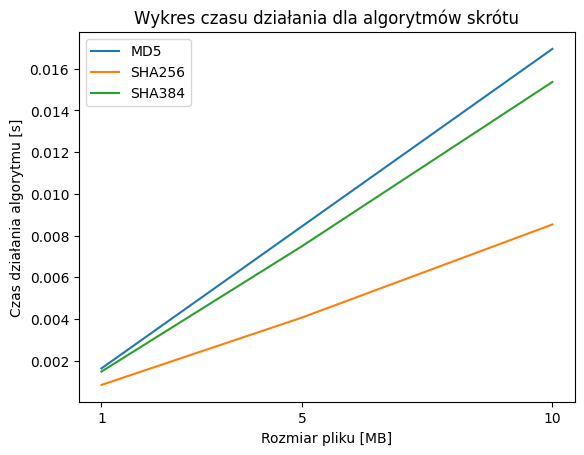

In [197]:
x = file_samples.copy()

plt.plot(x, md5_time, label="MD-5")
plt.plot(x, sha256_time, label="SHA-256")
plt.plot(x, sha384_time, label="SHA-384")

plt.xticks(x)
plt.xlabel('Rozmiar pliku [MB]')
plt.ylabel('Czas działania algorytmu [s]')
plt.title('Wykres czasu działania dla algorytmów skrótu')
plt.legend()
plt.show()

Jak widać, najszybciej radzi sobie algorytm SHA-256. Nieco wolniej radzą sobie algorytmy SHA-384 oraz MD-5.

Algorytmy SHA-384 i SHA-256 są oparte na tej samej konstrukcji, a różnią się jedynie długością wyniku (384 bity dla SHA-384 i 256 bitów dla SHA-256). Jednak SHA-384 wykonuje więcej rund obliczeń (80 rund) niż SHA-256 (64 rundy), co przekłada się na zwiększenie złożoności obliczeniowej. Dodatkowo SHA-384 korzysta z większych wartości początkowych i używa większych kluczy podczas przetwarzania danych wejściowych, co również wpływa na zwiększenie złożoności obliczeniowej.

### Porównywanie skrótów po zmianie jednego bitu
Dla każdego algorytmu oraz rozmiaru pliku sprawdzamy, jak wygląda skrót dla plików wypełnionych zerowymi bitami. Następnie sprawdzamy, jak wygląda skrót dla plików, które różnią się tylko jednym bitem na ostatniej pozycji względem wcześniejszych plików. Sprawdzamy jaki procent bitów się zmienił. Wyniki przedstawione zostały w tabeli.

In [199]:
def compare_hashes(samples, algorithm):
    hashes = []
    for sample in samples:
        create_file(sample)
        with open(f'{files_directory}/{sample}MB.txt', 'rb') as f:
            hash_obj_0 = algorithm(f.read())
            hash_0 = hash_obj_0.hexdigest()

        create_file(sample, amount_1_bin=1)
        with open(f'{files_directory}/{sample}MB.txt', 'rb') as f:
            hash_obj_1 = algorithm(f.read())
            hash_1 = hash_obj_1.hexdigest()

        hashes.append((sample, hash_0, hash_1))

    return hashes

def hex_to_bin(hex_str):
    hex_num = int(hex_str, 16)
    binary_str = bin(hex_num)[2:].zfill(len(hex_str) * 4)
    return [int(b) for b in binary_str]

def hash_difference_per(data_set_1, data_set_2):
    data_set = zip(hex_to_bin(data_set_1), hex_to_bin(data_set_2))
    difference_counter = sum([1 for x, y in data_set if x != y])

    return (difference_counter / len(hex_to_bin(data_set_1))) * 100


table = PrettyTable()
table.field_names = ["Nazwa algorytmu"] + [f"Zmienione bity (%) dla pliku {element}MB" for element in file_samples]

md5_hashes = compare_hashes(file_samples, hashlib.md5)
table.add_row(["MD5"] + [f"{round(hash_difference_per(x, y), 4)}%" for _, x, y in md5_hashes])

sha256_hashes = compare_hashes(file_samples, hashlib.sha256)
table.add_row(["SHA256"] + [f"{round(hash_difference_per(x, y), 4)}%" for _, x, y in sha256_hashes])

sha384_hashes = compare_hashes(file_samples, hashlib.sha384)
table.add_row(["SHA384"] + [f"{round(hash_difference_per(x, y), 4)}%" for _, x, y in sha384_hashes])

print(table.get_string())

+-----------------+----------------------------------+----------------------------------+-----------------------------------+
| Nazwa algorytmu | Zmienione bity (%) dla pliku 1MB | Zmienione bity (%) dla pliku 5MB | Zmienione bity (%) dla pliku 10MB |
+-----------------+----------------------------------+----------------------------------+-----------------------------------+
|       MD5       |              43.75%              |             42.9688%             |              54.6875%             |
|      SHA256     |             46.0938%             |             51.9531%             |              51.9531%             |
|      SHA384     |             49.7396%             |             48.9583%             |              48.9583%             |
+-----------------+----------------------------------+----------------------------------+-----------------------------------+


Jak widać, wyniki każdego algorytmu oscylują wokół 50%. Większą wariancję można zaobserwować w przypadku algorytmu MD5. Jest on mniej złożony od algorytmów z rodziny SHA, co może powodować mniejsze zmiany w przypadku zmian bitów.